In [1]:
import numpy as np
import h5py
import pathlib
from matplotlib import pyplot as plt
from scipy import signal
import json
import hampel
import pykalman
from mpl_toolkits import mplot3d


%matplotlib inline 
# %matplotlib notebook

In [2]:
data_folder=pathlib.Path("/media/mjsobrep/43CDA61E672B9161/pose")

In [3]:
hdf5_files={}
for subj_folder in data_folder.iterdir():
    if not subj_folder.is_dir():
        continue
    subj_no=subj_folder.parts[-1]
    fn=subj_folder/'robot'/'full_data-novid-poses-depth.hdf5'
    if (fn).exists():
        hdf5_files[subj_no]=h5py.File(fn,'r+')
    fn=subj_folder/'mixed'/'full_data-novid-poses-depth.hdf5'
    if (fn).exists():
        hdf5_files[subj_no]=h5py.File(fn,'r+')
    # note, subjects without data are just not added to dictionary

In [4]:
cutoff=2000
for subj in hdf5_files:
    if(len(hdf5_files[subj]['vid/lower/pose/openpose:25B/keypoints-median5/3d-realsense-raw'])<cutoff):
        print(f'bad data for {subj} lower camera openpose')
    if(len(hdf5_files[subj]['vid/upper/pose/mp-hands/left/keypoints-median5/3d-realsense-raw'])<cutoff):
        print(f'bad data for {subj} upper camera mp-hands left hand')
    if(len(hdf5_files[subj]['vid/upper/pose/mp-hands/right/keypoints-median5/3d-realsense-raw'])<cutoff):
        print(f'bad data for {subj} upper camera mp-hands right hand')
# hdf5_files['032']['vid/lower/pose/openpose:25B/keypoints-median5/3d-realsense-raw']
# hdf5_files['032']['vid/upper/pose/openpose:25B/keypoints-median5/3d-realsense-raw']

bad data for 060 lower camera openpose
bad data for 060 upper camera mp-hands left hand
bad data for 060 upper camera mp-hands right hand
bad data for 500-3 lower camera openpose
bad data for 500-3 upper camera mp-hands left hand
bad data for 500-3 upper camera mp-hands right hand


In [5]:
subj = '031'

def print_attrs(name, obj):
    print(name)
    
hdf5_files[subj].visititems(print_attrs)

client_count
client_count/data
client_count/time
diagnostics
diagnostics/data
diagnostics/time
diagnostics_toplevel_state
diagnostics_toplevel_state/data
diagnostics_toplevel_state/time
face_state
face_state/data
face_state/time
game_runner
game_runner/actions
game_runner/actions/data
game_runner/actions/time
game_runner/command_opts
game_runner/command_opts/data
game_runner/command_opts/time
game_runner/commands
game_runner/commands/data
game_runner/commands/time
game_runner/def
game_runner/def/data
game_runner/def/time
game_runner/state
game_runner/state/data
game_runner/state/time
game_runner/text
game_runner/text/data
game_runner/text/time
joint_states
joint_states/data
joint_states/time
mobile_base
mobile_base/commands
mobile_base/commands/velocity
mobile_base/commands/velocity/data
mobile_base/commands/velocity/time
mobile_base/sensors
mobile_base/sensors/imu_data
mobile_base/sensors/imu_data/data
mobile_base/sensors/imu_data/time
motor_commands
motor_commands/data
motor_commands

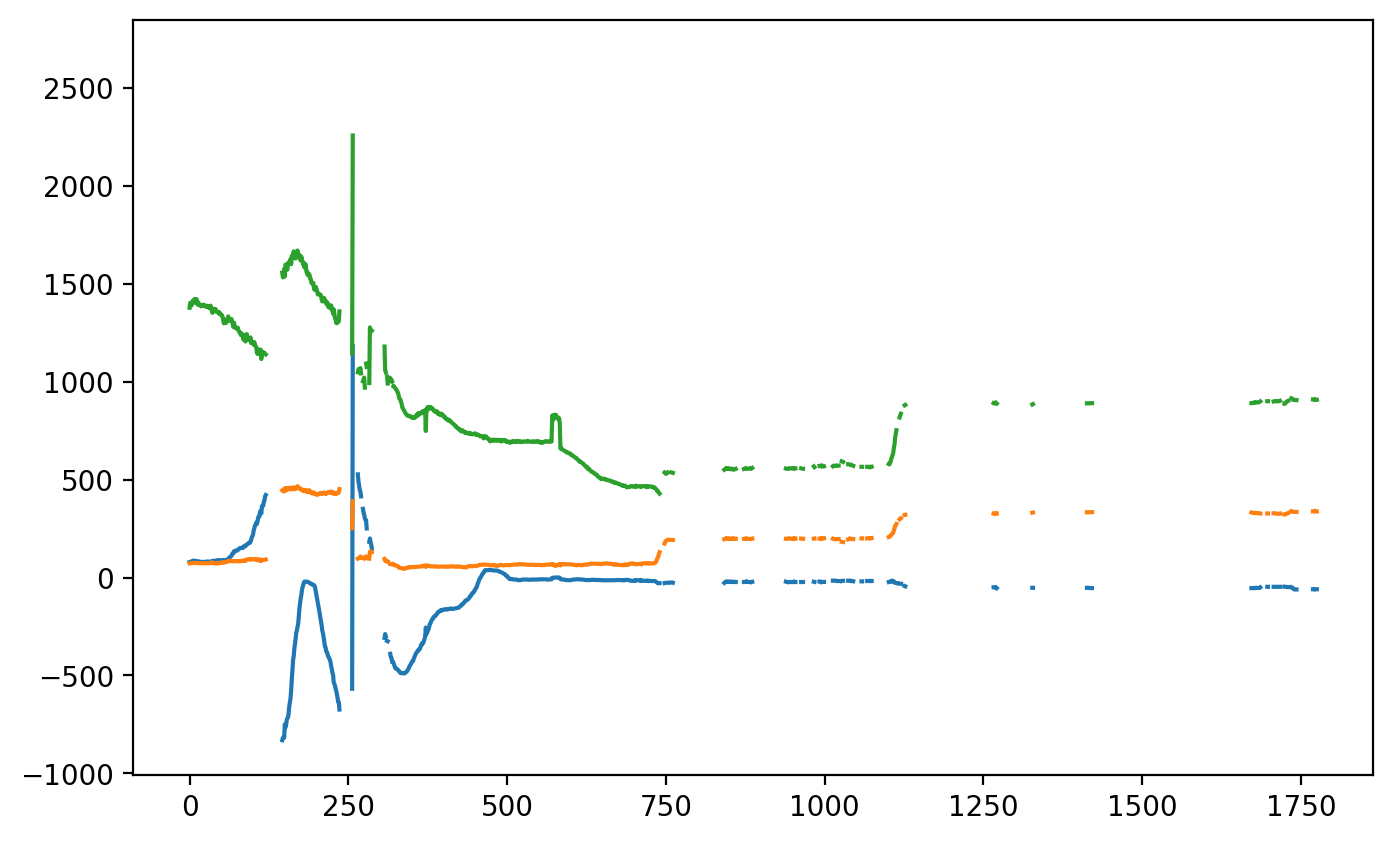

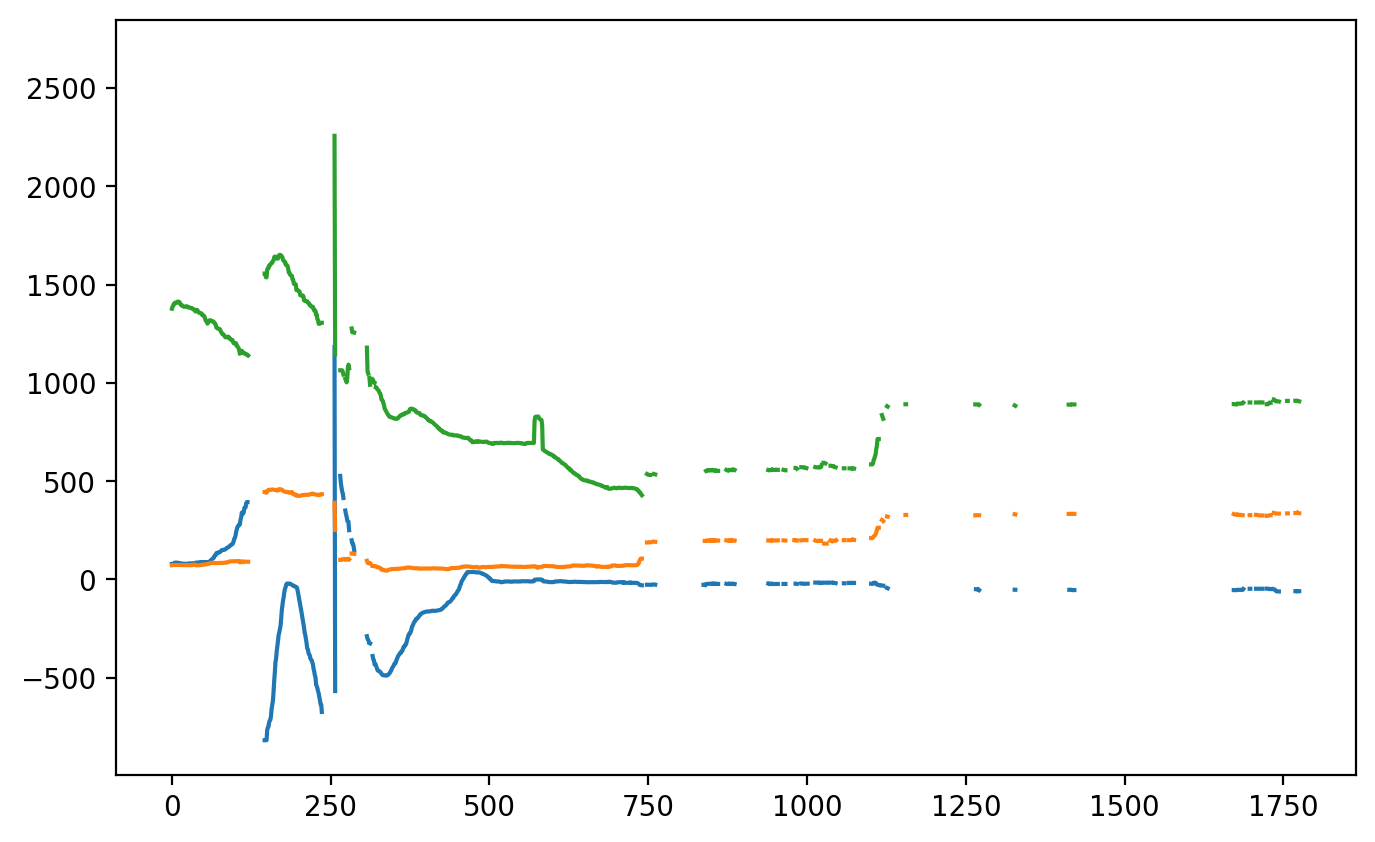

In [6]:
start=10000
num_points=3000

plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
# signal.medfilt(Zs[~Zs.mask[:,0],:], kernel_size=[5,1])
plt.plot(hdf5_files[subj]['vid/lower/pose/openpose:25B/keypoints-median5/3d-realsense-raw'][start:start+num_points,10,:])

plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
# signal.medfilt(Zs[~Zs.mask[:,0],:], kernel_size=[5,1])
plt.plot(signal.medfilt(hdf5_files[subj]['vid/lower/pose/openpose:25B/keypoints-median5/3d-realsense-raw'][start:start+num_points,10,:], kernel_size=[5,1]))

In [7]:
def openpose_joints():
    """Return a list with the joints produced by openpose
    """
    return [
        "Nose",
        "LEye",
        "REye",
        "LEar",
        "REar",
        "LShoulder",
        "RShoulder",
        "LElbow",
        "RElbow",
        "LWrist",
        "RWrist",
        "LHip",
        "RHip",
        "LKnee",
        "RKnee",
        "LAnkle",
        "RAnkle",
        "UpperNeck",
        "HeadTop",
        "LBigToe",
        "LSmallToe",
        "LHeel",
        "RBigToe",
        "RSmallToe",
        "RHeel"
    ]
np.where(np.asarray(openpose_joints())=='RWrist')

(array([10]),)

In [8]:
openpose_joints()

['Nose',
 'LEye',
 'REye',
 'LEar',
 'REar',
 'LShoulder',
 'RShoulder',
 'LElbow',
 'RElbow',
 'LWrist',
 'RWrist',
 'LHip',
 'RHip',
 'LKnee',
 'RKnee',
 'LAnkle',
 'RAnkle',
 'UpperNeck',
 'HeadTop',
 'LBigToe',
 'LSmallToe',
 'LHeel',
 'RBigToe',
 'RSmallToe',
 'RHeel']

In [9]:
np.where(hdf5_files[subj]['/game_runner/commands/data'][:]==b'next')[0][-1]

105

In [10]:
game_start_idx=np.where(hdf5_files[subj]['/game_runner/commands/data'][:]==b'start')
game_finish_idx=np.where(hdf5_files[subj]['/game_runner/commands/data'][:]==b'finish_game')
game_start_times=hdf5_files[subj]['/game_runner/commands/time'][game_start_idx]
print(game_start_times)
game_finish_times=hdf5_files[subj]['/game_runner/commands/time'][game_finish_idx]
print(game_finish_times)

[1.62525113e+09 1.62525148e+09 1.62525246e+09 1.62525275e+09]
[1.62525140e+09 1.62525203e+09 1.62525272e+09]


The person running the game doesn't always end it in the ftf condition. If there is no end time, we can take the last command time...

In [11]:
game_types=[json.loads(arr)['game_type'] for arr in hdf5_files[subj]['/game_runner/def/data']]
print(game_types)
[arr for arr in hdf5_files[subj]['/game_runner/def/time']]

['simon_says', 'target_touch', 'simon_says', 'target_touch']


[1625251121.1225924, 1625251476.047082, 1625252456.0893817, 1625252721.7949948]

In [12]:
# match start and end times to game name:
game_start_idx=np.where(hdf5_files[subj]['/game_runner/commands/data'][:]==b'start')
game_finish_idx=np.where(hdf5_files[subj]['/game_runner/commands/data'][:]==b'finish_game')
games = {}
games['type']=[json.loads(arr)['game_type'] for arr in hdf5_files[subj]['/game_runner/def/data']]
games['type_time']=hdf5_files[subj]['/game_runner/def/time'][:]
games['start']=hdf5_files[subj]['/game_runner/commands/time'][game_start_idx]
games['finish']=hdf5_files[subj]['/game_runner/commands/time'][game_finish_idx]

# make sure that each end falls between the previous and next start
num_games=len(games['type'])
for idx in range(num_games):
    if games['start'][idx]<games['type_time'][idx]:
        # this start is not the right one. add a start at the game load time
        print('inserted an extra start')
        games['start']=np.insert(games['start'],idx,games[type_time])
    if idx+1>len(games['finish']):
        # we have already fixed everything else, just missing an end. Just find it...
        print('added an end to the end')
        last_command_idx=np.where(hdf5_files[subj]['/game_runner/commands/data'][:]==b'next')[0][-1]
        last_command_time=hdf5_files[subj]['/game_runner/commands/time'][last_command_idx]
        games['finish']=np.append(games['finish'],last_command_time)
    # check that finish comes after the expected start and before the next start
    if games['finish'][idx]<=games['start'][idx]:
        raise RuntimeError
    # if this is the last item, only check previous one
    if idx+1==len(games['start']):
        continue
    if games['finish'][idx]>=games['start'][idx+1]:
        raise RuntimeError
        
games

added an end to the end


{'type': ['simon_says', 'target_touch', 'simon_says', 'target_touch'],
 'type_time': array([1.62525112e+09, 1.62525148e+09, 1.62525246e+09, 1.62525272e+09]),
 'start': array([1.62525113e+09, 1.62525148e+09, 1.62525246e+09, 1.62525275e+09]),
 'finish': array([1.62525140e+09, 1.62525203e+09, 1.62525272e+09, 1.62525291e+09])}

In [13]:
games['finish']-games['start']

array([271.48497605, 545.25682163, 260.23989654, 160.29371762])

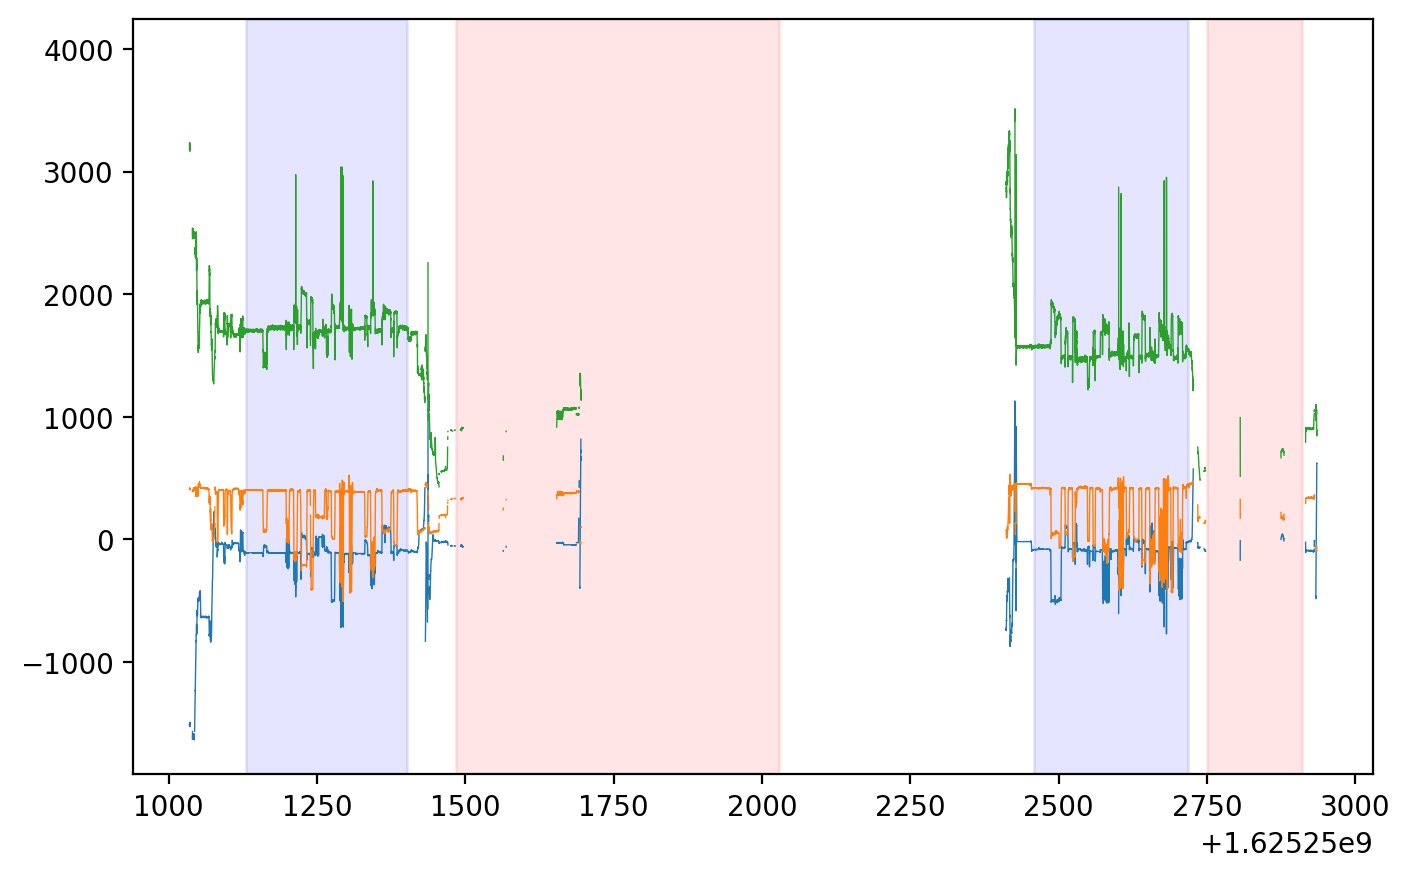

In [14]:
#visualize for wrist
time_name='vid/lower/color/time'
keypoint_name='vid/lower/pose/openpose:25B/keypoints-median5/3d-realsense-raw'
game_idx=2

plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
# signal.medfilt(Zs[~Zs.mask[:,0],:], kernel_size=[5,1])
plt.plot(hdf5_files[subj][time_name][:], hdf5_files[subj][keypoint_name][:,10,:],linewidth=0.5)

for idx in range(num_games):
    plt.axvspan(games['start'][idx], games['finish'][idx], alpha=0.1, color=('blue' if games['type'][idx]=='simon_says' else 'red'))


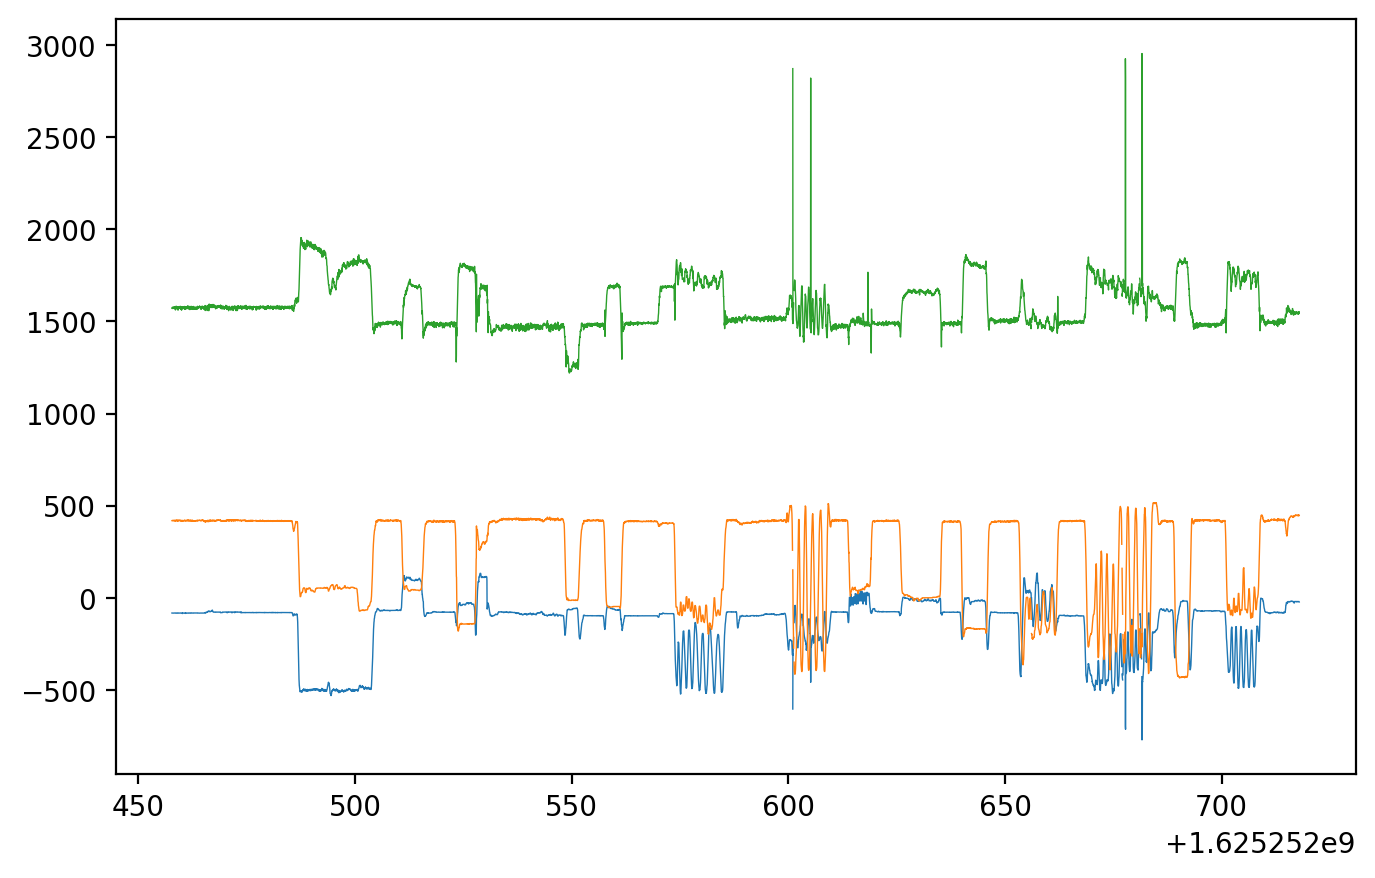

In [15]:
# look a first simon says game:
start_t=games['start'][game_idx]
finish_t=games['finish'][game_idx]
start_idx=np.argmax(hdf5_files[subj][time_name][:]>start_t)
finish_idx=np.argmax(hdf5_files[subj][time_name][:]>finish_t)

game_time=hdf5_files[subj][time_name][start_idx:finish_idx]
game_pose=hdf5_files[subj][keypoint_name][start_idx:finish_idx,10,:]

plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
# signal.medfilt(Zs[~Zs.mask[:,0],:], kernel_size=[5,1])
plt.plot(game_time, game_pose, linewidth=.5)

In [16]:
# outlier rejection: find iqr for 10 points above and below point
# if point outside of median+IQR, then replace with median
def hampel_filt(data, half_win_length, threshold):
    data=np.ma.array(data)
    data[np.isnan(data)]=np.ma.masked
    bad_idx=np.array([],dtype='int')
    mad_arr=np.zeros((len(data)))
    med_arr=np.zeros((len(data)))
    for (idx, dp), not_valid in zip(enumerate(data), data.mask):
        if np.isnan(dp):
            continue
        if not_valid:
            continue
        lower_bound = np.max([0,idx-half_win_length])
        upper_bound = np.min([len(data)-1,idx+half_win_length])
        windowed_data= data[lower_bound:upper_bound]
        median = np.ma.median(windowed_data)
        mad = np.ma.median(np.abs(windowed_data-median))
        mad_arr[idx]=mad
        med_arr[idx]=np.abs(data[idx]-median)
        if np.abs(data[idx]-median) > mad*threshold:
            bad_idx = np.append(bad_idx, idx)
#     return (bad_idx, mad_arr, med_arr)
    return bad_idx

# bad_z,mad,med=hampel_filt(game_pose[:,2],10,.1)

In [17]:
bad_vals = np.unique(np.concatenate([hampel_filt(game_pose[:,axis],10,3) for axis in range(3)], axis=0))

In [18]:
len(bad_vals)/len(game_pose)

0.10964054745074447

In [19]:
game_pose[bad_vals,:]=np.nan

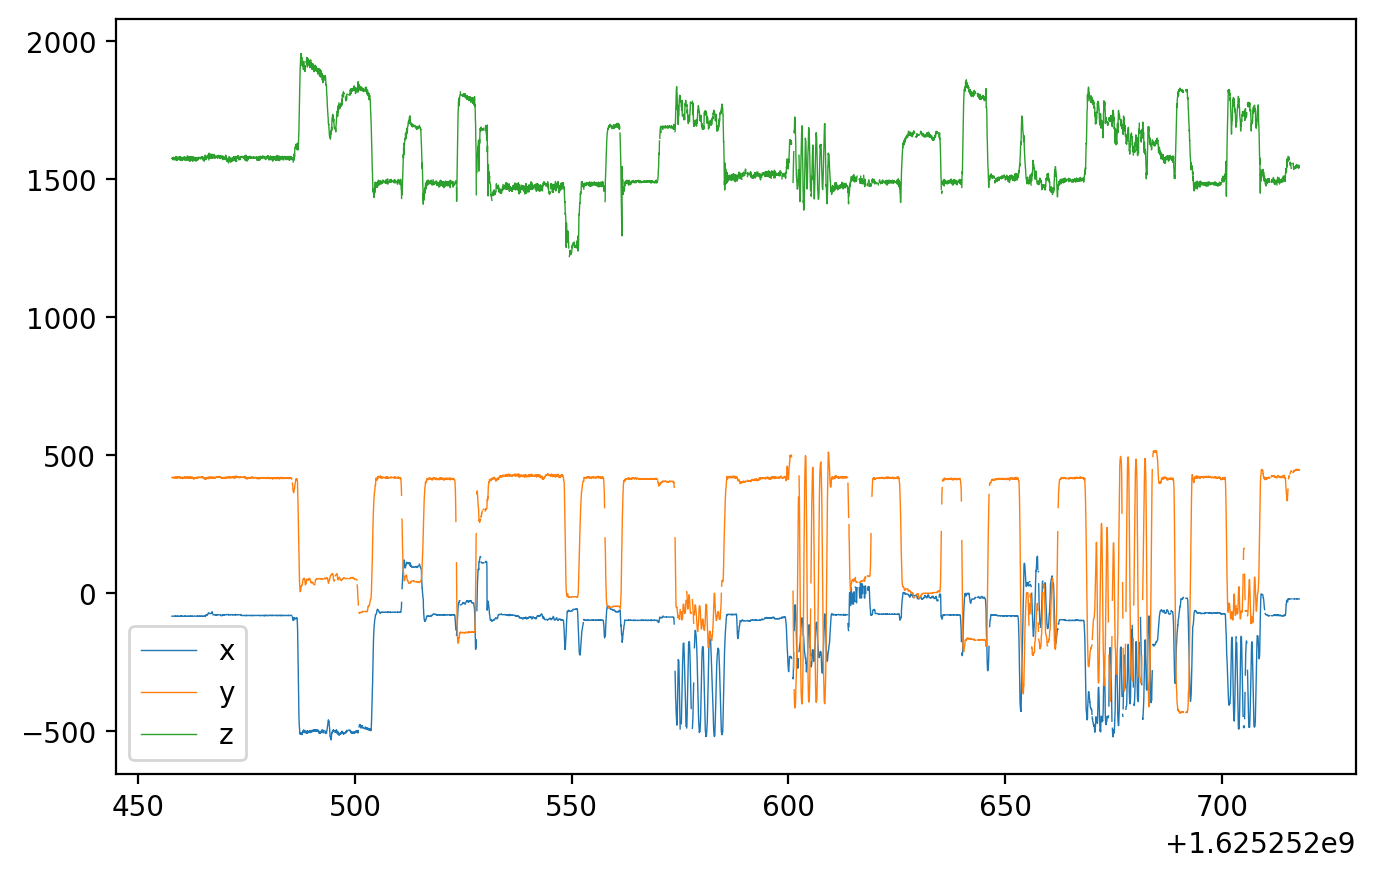

In [20]:
plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(game_time, game_pose, linewidth=.5)
# plt.plot(game_time[bad_vals],np.ones(len(bad_vals))*1000,'.',markersize=.1)
plt.legend(['x','y','z'])

In [21]:
np.where(game_pose[:,2]>2500)

(array([], dtype=int64),)

In [118]:
# Now kalman smoother to 1) smooth and 2) get velocity and acceleration
# Measurement function (we measure x, y, and z positions)
H = np.array([[1,0,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0,0],
             ])

# P0 = np.array([[0,0,0,0,0,0,0,0,0], # initially could be anywhere, let's assume that they are in front of the camera and about 1 meter away
#                [0,0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0,0], # assume no velocity or accel
#                [0,0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0,0]
#               ])
# Transistion covariance - assume velocity only changes due to acceleration and position only changes due to velocity
Q = [np.array([[0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,1,0,0],
               [0,0,0,0,0,0,0,1,0],
               [0,0,0,0,0,0,0,0,1]
              ])*((100000*dt)**2) for dt in np.diff(game_time)]
# where to get acceleration: 
# - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4689593/#:~:text=Most%20movements%20were%20about%200.2,5%20and%2030%20cm%2Fs.
# - 5000 mm/s^2 : https://doi.org/10.5281/zenodo.1098112
# - 20,000 mm/s^2 (fast, upward swing) 7k mm/s^2 (normal)  : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3134452/
# So then what is the standard deviation of motion?

# Need to focus on jerk, that defines the process progression of acceleration. From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3134452/
# FAST 2-3 SD?:
# peak accel = 20 m/s^2
# Time to peak accel = .1 s
# Jerk = 20 m/s^2 / .1 s = 200 m/s^3 = 200,000 mm/s^3
# NORMAL:
# peak accel = 7 m/s^2
# Time to peak accel = .125 s
# Jerk = 7 m/s^2 / .125 s = 56 m/s^3 = 56000 mm/s^3

# FROM https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5350272/
# Normal Jerk for reaching motion ~ 10,000 cm/s^3 = 100,000 mm/s^3

# Observation covariance
R=[[30**2,     0,     0],
   [    0, 30**2,     0],
   [    0,     0, 80**2]]
# RealSense is +/- 2% (https://www.intelrealsense.com/wp-content/uploads/2022/03/Intel-RealSense-D400-Series-Datasheet-March-2022.pdf)
# so that is the z uncertainty. Because we use z for getting x y position from pixels, this affects x and y as well. If we think 
# about what just the pixel accuracy leads to, expect openpose to be +/- 15 pixels? at 1 meter away, d415 color horiz 69 deg, vert 42 deg
# so with horiz resolution 1920 at
#    - 1 meter, 1.374 meters across frame -> .72 mm/pixel so like +/- 10mm for openpose
#    - 2 meter, 2.75 meters across frame -> 1.43 mm / pixel so like +/- 21.5 mm
#    - call it +/- 15 mm?
# and +/- 20 mm for realsense at 1 meter, +/- 40 mm at 2 m. 
# Because these are coupled and I don't know how to handle the coupling, I am just going to double the sd... 
# We could use the confidence of the pose detection as well, not sure what confidence actually translates to though

# State transistion matrix
Fs = [np.array([[1, 0, 0, dt,  0,  0, 1/2*(dt**2),           0,           0],
                [0, 1, 0,  0, dt,  0,           0, 1/2*(dt**2),           0],
                [0, 0, 1,  0,  0, dt,           0,           0, 1/2*(dt**2)],
                [0, 0, 0,  1,  0,  0,          dt,           0,           0],
                [0, 0, 0,  0,  1,  0,           0,          dt,           0],
                [0, 0, 0,  0,  0,  1,           0,           0,          dt],
                [0, 0, 0,  0,  0,  0,           1,           0,           0],
                [0, 0, 0,  0,  0,  0,           0,           1,           0],
                [0, 0, 0,  0,  0,  0,           0,           0,           1]
               ]) for dt in np.diff(game_time)]

kf = pykalman.KalmanFilter(transition_matrices=Fs, observation_matrices=H, 
#                             initial_state_mean=x0, #initial_state_covariance=P0,
                             observation_covariance=R, transition_covariance=Q)

In [119]:
.72*15

10.799999999999999

In [120]:
game_pose_masked=np.ma.array(game_pose)
game_pose_masked[np.isnan(game_pose_masked)]=np.ma.masked
# Initial vals
init_meds = np.ma.median(game_pose_masked[:20],axis=0)
kf.initial_state_mean=np.array([init_meds[0],init_meds[1],init_meds[2],0,0,0,0,0,0]) 
xs, _ = kf.smooth(game_pose_masked)

In [121]:
kf.em(game_pose_masked, em_vars=['observation_covariance','transition_covariance'])
xs2, _ = kf.smooth(game_pose_masked)

In [122]:
kf.observation_covariance-R

array([[ -889.85806085,    -0.42681468,    -4.06528822],
       [   -0.42681468,  -890.10135585,     8.32091509],
       [   -4.06528822,     8.32091509, -6333.06133267]])

In [123]:
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=150)
print(np.round(kf.transition_covariance-np.median(Q,axis=0)))

[[       0.       -0.       -0.        0.       -0.       -0.        0.       -0.       -0.]
 [      -0.       -0.        0.       -0.       -0.        0.       -0.       -0.        0.]
 [      -0.        0.        0.       -0.        0.        0.        0.       -0.        0.]
 [       0.       -0.       -0.        0.        0.        0.        0.       -0.       -0.]
 [      -0.       -0.        0.       -0.       -0.       -0.        0.        0.        0.]
 [       0.        0.       -0.       -0.        0.        0.       -0.       -0.       -0.]
 [       0.       -0.        0.        0.        0.       -0. -8225841.   277495.   226147.]
 [      -0.       -0.       -0.       -0.        0.       -0.   277495. -8318473.   377658.]
 [       0.       -0.       -0.        0.        0.       -0.   226147.   377658. -8417755.]]


In [124]:
def plot_model_results(times,raw_data, model_output, start_idx=0, num_idx=None, title=None):
    if num_idx is None:
        num_idx=len(times)-start_idx
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(8,5), dpi= 200)
    ax1.plot(times[start_idx:start_idx+num_idx], raw_data[start_idx:start_idx+num_idx,0:3],linewidth=1,alpha=0.3)
    ax1.plot(times[start_idx:start_idx+num_idx], model_output[start_idx:start_idx+num_idx,0:3],linewidth=.5,alpha=.8)
    ax1.legend(['x-raw','y-raw','z-raw','x','y','z'])
    ax2.plot(times[start_idx:start_idx+num_idx], model_output[start_idx:start_idx+num_idx,3:6],linewidth=0.5,alpha=.8)
    ax2.legend(['dx','dy','dz'])
    ax3.plot(times[start_idx:start_idx+num_idx], model_output[start_idx:start_idx+num_idx,6:9],linewidth=0.5,alpha=.8)
    ax3.legend(['ddx','ddy','ddz'])
    if title:
        fig.suptitle(title)

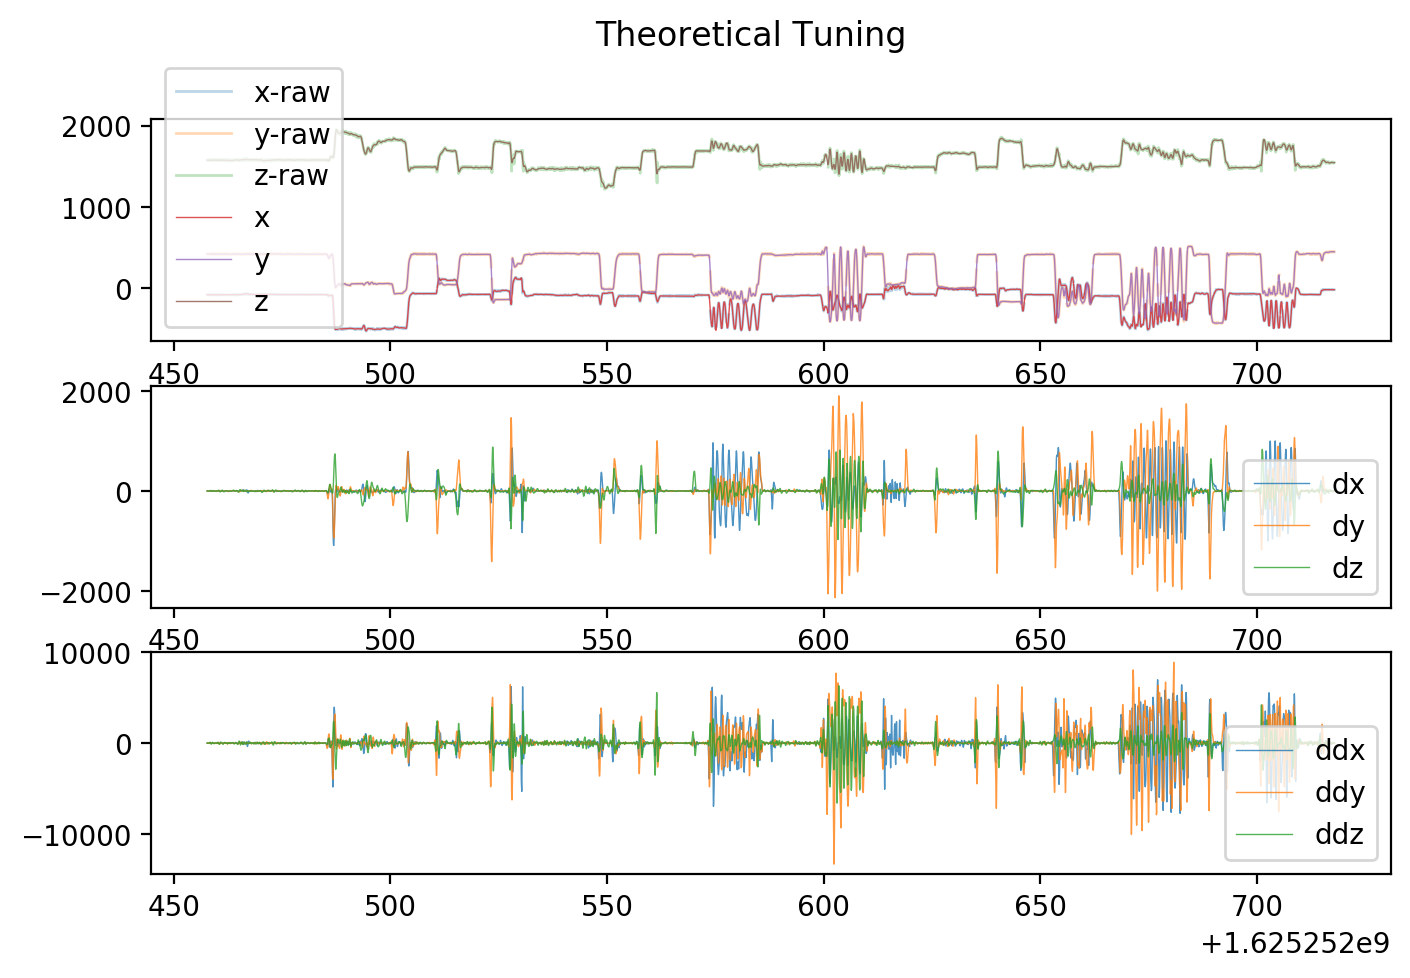

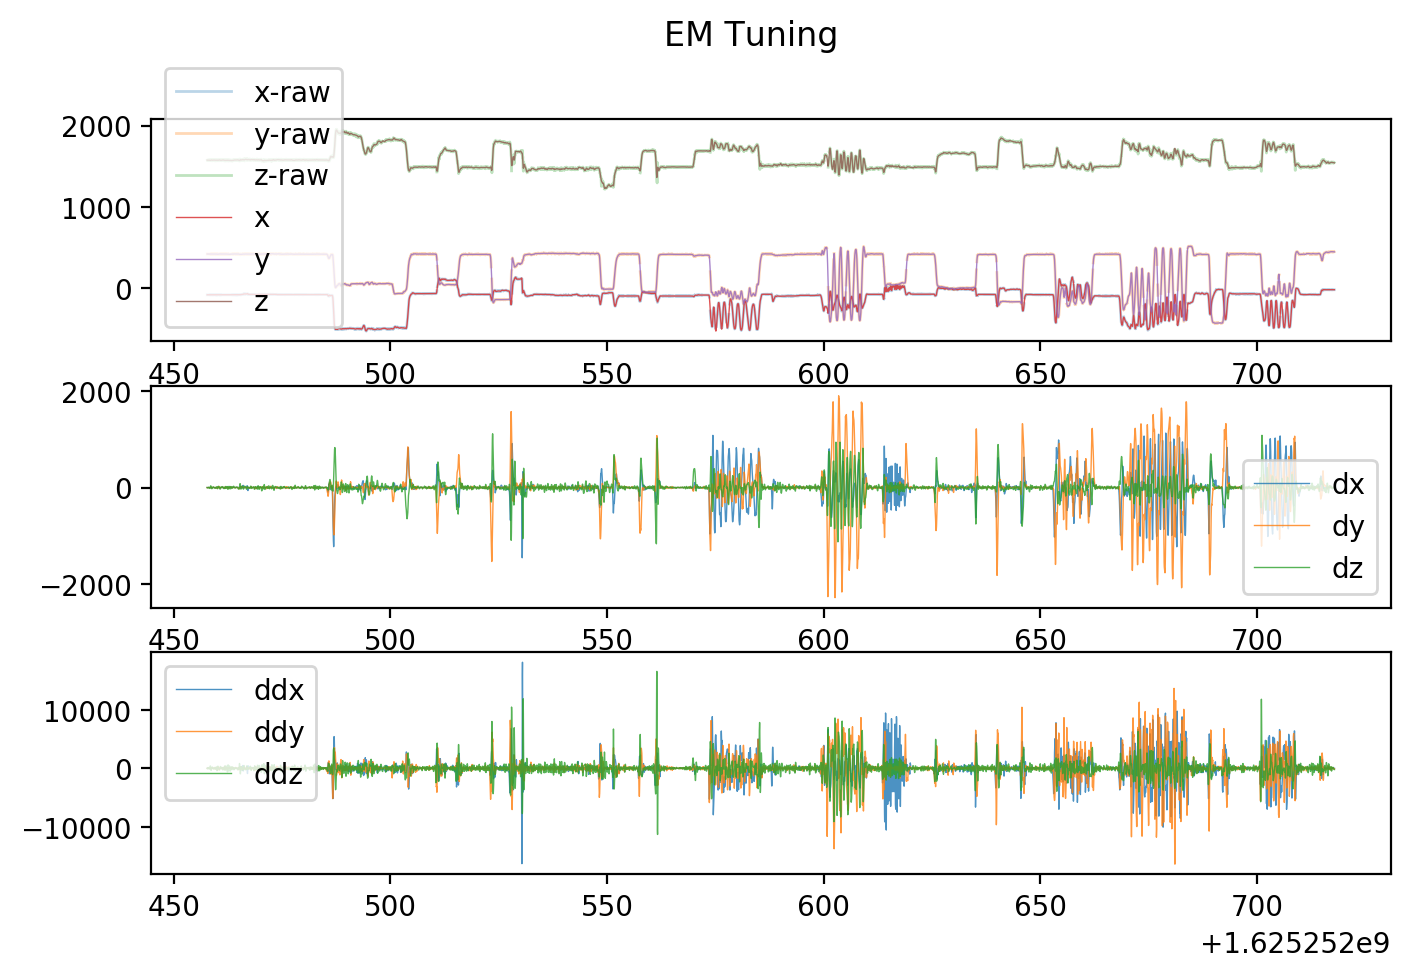

In [125]:
plot_model_results(game_time, game_pose_masked, xs, title='Theoretical Tuning')
plot_model_results(game_time, game_pose_masked, xs2, title='EM Tuning')

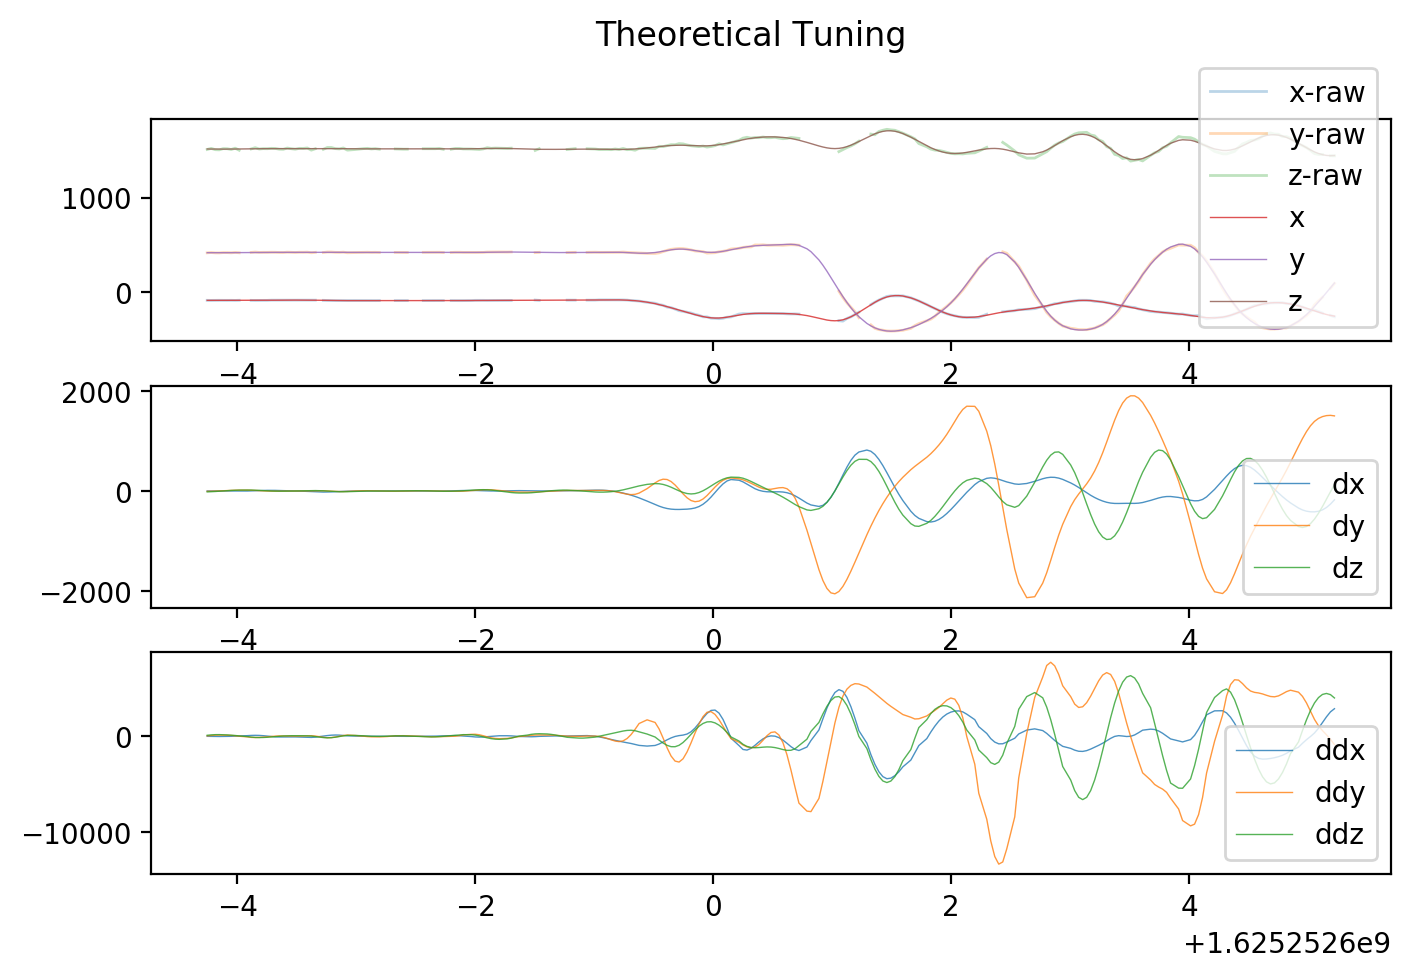

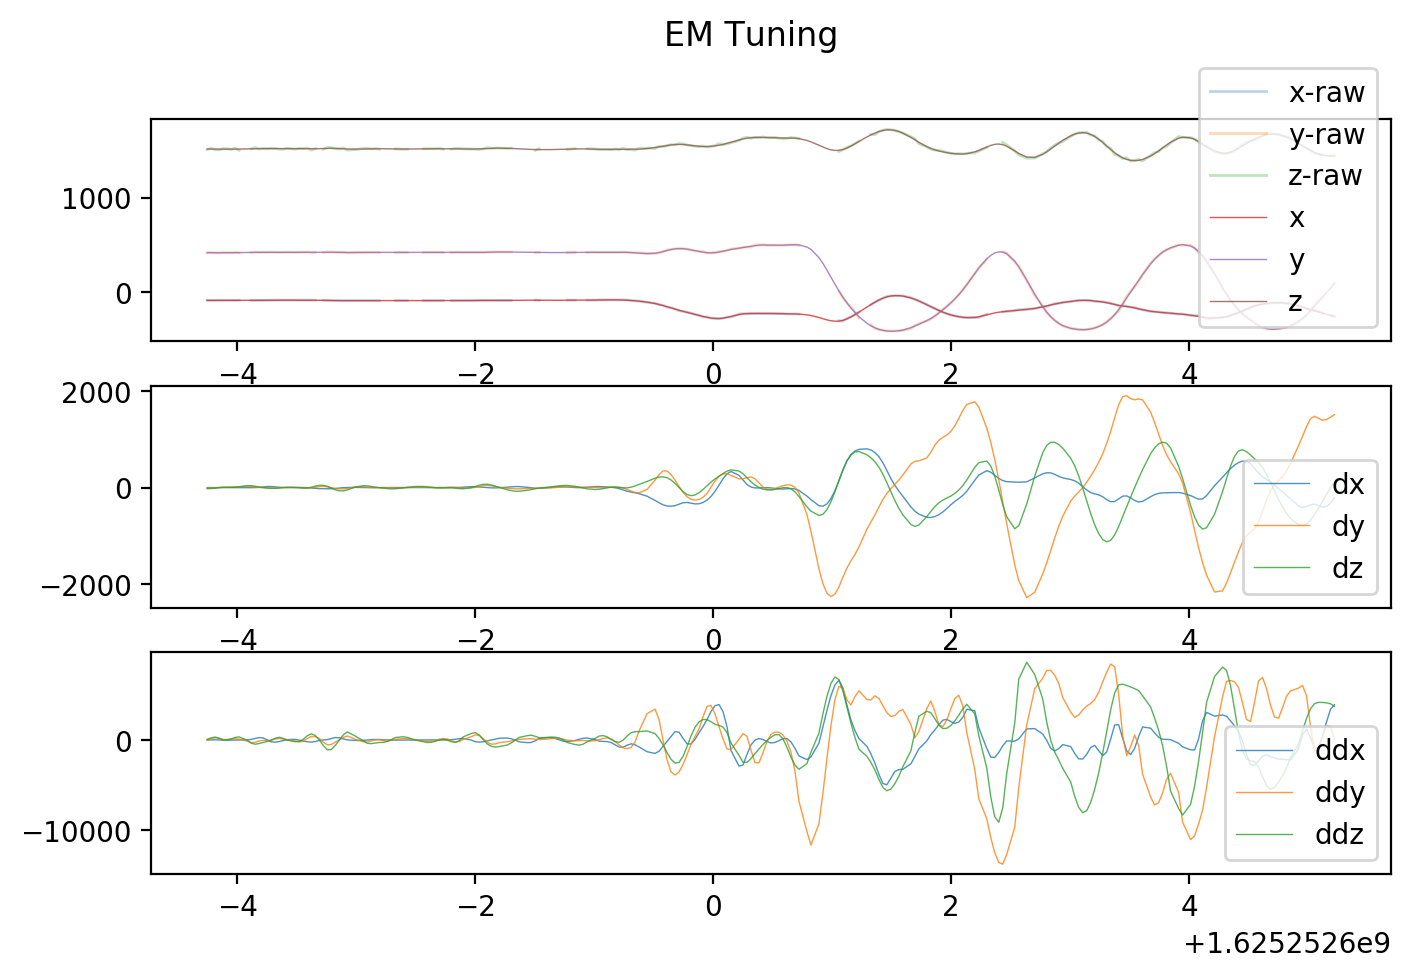

In [126]:
st=3500
num_idx=250
plot_model_results(game_time,game_pose_masked, xs,st, num_idx, title="Theoretical Tuning")
plot_model_results(game_time,game_pose_masked, xs2, st, num_idx, title="EM Tuning")

Huh, my values actually look better than the em fit values

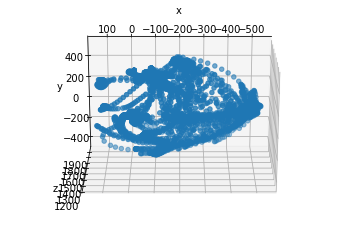

In [127]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(xs[:,0],xs[:,1],xs[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(-70, 90)